In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import log_loss

Sheet with testing of different confounding variables: https://docs.google.com/spreadsheets/d/10wTSK-a4Y7gjelasdb7eHcjVxjx7LWEVv1zBUqDI88Q/edit?usp=sharing

In [4]:
codebook = pd.read_csv('RECS 2020 Codebook for Public File - v7.csv').iloc[:,0:3]
energy = pd.read_csv('recs2020_public_v7.csv')
energy.head()
energy.shape[0]

18496

In [7]:
len(energy[energy['ENERGYASST20']==0])

292

In [10]:
len(energy[energy['ENERGYASST20']==1])

562

In [13]:
# Convert -2 in ENERGYASST20 to 0 
# A flaw in our model to consider because we are not sure the origin/purpose of -2 
#conversion = {-2:0, 1:1, 0:0}
#energy['ENERGYASST20'] = energy['ENERGYASST20'].map(conversion)

In [16]:
filtered_energy = energy[energy['ENERGYASST20']!=-2]

In [19]:
# DECIDED NOT TO USE BC DID NOT HELP MODEL ACCURACY
# block to map state names to numbers 
states = [
    "Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware","District of Columbia",
    "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", 
    "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota", "Mississippi", 
    "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico", 
    "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", 
    "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", 
    "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"
]

# create the mapping dictionary (1-51)
state_to_number = {state: i+1 for i, state in enumerate(sorted(states))}

# Map the state names to numbers
filtered_energy['state_number'] = filtered_energy['state_name'].map(state_to_number)

filtered_energy[['state_name', 'state_number']].head()
#filtered_energy[filtered_energy['state_number'].isna()][['state_name', 'state_number']]

/tmp/ipykernel_41/2268027584.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_energy['state_number'] = filtered_energy['state_name'].map(state_to_number)


,state_name,state_number
13,Minnesota,24
20,Illinois,14
24,Illinois,14
27,Massachusetts,22
42,California,5


In [22]:
Z = filtered_energy['ENERGYASST20'].to_numpy() # The treatment is receiving energy assistance in 2020
Y = filtered_energy['KWH'].to_numpy() # The outcome variable is total electricity usage (in kWh) in 2020
X = filtered_energy[['MONEYPY', 'NHSLDMEM', 'ATHOME', 'NUMCHILD', 'NUMADULT1', 'NUMADULT2', 
            'HOUSEHOLDER_RACE','EDUCATION', 'EMPLOYHH', 'ELPAY']].to_numpy() #Variables used to train the logistic regression

In [25]:
#Create a logistic regression model to predict Z from X 
lr = LR(penalty='none', max_iter=200, random_state=42)
e_model = lr.fit(X, Z)

In [28]:
#Define a function that uses propensity scores to predict Y
def estimate_treatment_effect(fitted_lr, X, Y, Z):
    ehats = fitted_lr.predict_proba(X)[:,1] #Predict Z from X
    prune_indices = (ehats > 0.1) & (ehats < 0.9)
    Z = Z[prune_indices]
    Y = Y[prune_indices]
    ehats = ehats[prune_indices]
    effect = np.mean(Z*Y / ehats - (1-Z)*Y / (1-ehats))
    return ehats, effect, prune_indices

In [31]:
ehats, est_effect, p_i = estimate_treatment_effect(e_model, X, Y, Z)
est_effect

535.2712428234769

In [34]:
log_loss(Z[p_i], ehats)

0.6115639560323927

In [37]:
mean_kwh_no_asst = np.mean(energy[energy['ENERGYASST20']==0]['KWH'])
mean_kwh_asst = np.mean(energy[energy['ENERGYASST20']==1]['KWH'])
print("Mean KWH used with no energy assistance:", mean_kwh_no_asst)
print("Mean KWH used with energy assistance:", mean_kwh_asst)

Mean KWH used with no energy assistance: 9295.864554794522
Mean KWH used with energy assistance: 9574.555836298932


In [40]:
# find accuracy
from sklearn.metrics import accuracy_score
import matplotlib as plt

Z_hat = (ehats >= 0.5).astype(int)
accuracy = accuracy_score(Z[p_i], Z_hat)
print("Model accuracy: ", accuracy)

Model accuracy:  0.6822977725674091


In [43]:
# A/B test
filtered_energy = energy[energy['ENERGYASST20']!=-2]

iter = 10000
est_effects = []
for i in range(iter):
    sampled_energy = filtered_energy.copy(deep=True)
    sampled_energy["new_label"] = filtered_energy["ENERGYASST20"].sample(n=len(filtered_energy), replace=False).values
    #display(sampled_energy[["new_label", "ENERGYASST20"]].head())
    Z = sampled_energy['new_label'].to_numpy() # The treatment is receiving energy assistance in 2020
    Y = sampled_energy['KWH'].to_numpy() # The outcome variable is total electricity usage (in kWh) in 2020
    X = sampled_energy[['MONEYPY', 'NHSLDMEM', 'ATHOME', 'NUMCHILD', 'NUMADULT1', 'NUMADULT2', 
            'HOUSEHOLDER_RACE','EDUCATION', 'EMPLOYHH', 'ELPAY']].to_numpy() #Variables used to train the logistic regression

    #Create a logistic regression model to predict Z from X 
    lr = LR(penalty='none', max_iter=200)
    e_model = lr.fit(X, Z)

    ehats, est_effect, p_i = estimate_treatment_effect(e_model, X, Y, Z)
    est_effects.append(est_effect)

Z = filtered_energy['ENERGYASST20'].to_numpy() # The treatment is receiving energy assistance in 2020
Y = filtered_energy['KWH'].to_numpy() # The outcome variable is total electricity usage (in kWh) in 2020
X = filtered_energy[['MONEYPY', 'NHSLDMEM', 'ATHOME', 'NUMCHILD', 'NUMADULT1', 'NUMADULT2', 
        'HOUSEHOLDER_RACE','EDUCATION', 'EMPLOYHH', 'ELPAY']].to_numpy() #Variables used to train the logistic regression

#Create a logistic regression model to predict Z from X 
lr = LR(penalty='none', max_iter=200)
e_model = lr.fit(X, Z)

ehats, est_effect, p_i = estimate_treatment_effect(e_model, X, Y, Z)

p = sum(est_effect <= est_effects) / len(est_effects)
print(est_effect, p)

535.2712428234769 0.1085


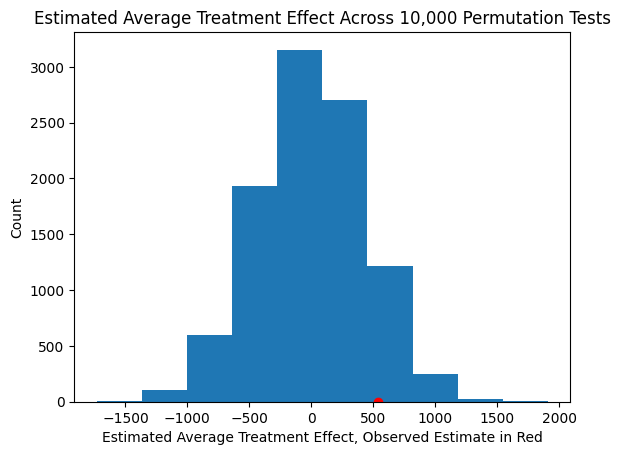

In [50]:
plt.figure()
plt.title("Estimated Average Treatment Effect Across 10,000 Permutation Tests")
plt.xlabel("Estimated Average Treatment Effect, Observed Estimate in Red")
plt.ylabel("Count")
plt.hist(est_effects)
plt.scatter(est_effect, 0, color='red')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e7c7e5ea-85f8-4ba1-a144-22a3b75e26c3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>